### Install Prerequisite

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn Caribe
!pip install gradio jinja2

### Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('C:/Users/JOY/Desktop/Final Project')

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy

import Caribe as cb
import gradio as gr

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [7]:
df = pd.read_csv(os.path.join('datasets/jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

column_names=["short","long"]
df1 = pd.read_csv("datasets/abbrevations.csv",names=column_names)
df2 = pd.read_csv("datasets/emoji_df.csv")
df3 = pd.read_csv("datasets/twitterSlang.csv")

In [8]:
df.head()

,id,comment_text,Toxic,Severe Toxic,Obscene,Threat,Insult,Identity Hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Vectorization

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [10]:
vectorizer = TextVectorization(max_tokens=200000,output_sequence_length=1800,output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) 

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### BI-LSTM Sequential Model

In [11]:
model = Sequential()

model.add(Embedding(200000+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

### Summarize Model

In [12]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

### Train Model

In [13]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 6262s 896ms/step - loss: 0.0632 - accuracy: 0.9877 - val_loss: 0.0456 - val_accuracy: 0.9947
Epoch 2/5
6981/6981 [==============================] - 4170s 597ms/step - loss: 0.0459 - accuracy: 0.9942 - val_loss: 0.0408 - val_accuracy: 0.9944
Epoch 3/5
6981/6981 [==============================] - 1430s 205ms/step - loss: 0.0404 - accuracy: 0.9941 - val_loss: 0.0362 - val_accuracy: 0.9942
Epoch 4/5
6981/6981 [==============================] - 1379s 197ms/step - loss: 0.0367 - accuracy: 0.9943 - val_loss: 0.0303 - val_accuracy: 0.9942
Epoch 5/5
6981/6981 [==============================] - 1395s 200ms/step - loss: 0.0317 - accuracy: 0.9940 - val_loss: 0.0281 - val_accuracy: 0.9949


### Ploting Accuracy vs Loss

<Figure size 576x360 with 0 Axes>

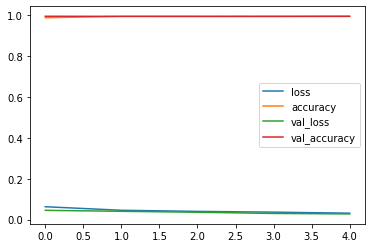

In [14]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Model Predictions

In [15]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [16]:
res = model.predict(np.array([input_text]))

In [17]:
(res > 0.1).astype(int)

array([[1, 1, 1, 0, 1, 1]])

### Save the Model

In [18]:
model.save('models/toxicity052.h5')

### Model Evaluation

In [39]:
model = tf.keras.models.load_model('models/toxicity052.h5')

In [42]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    
    X_true, y_true = batch
    
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

F1 = 2 * ((pre.result().numpy()) * (re.result().numpy())) / ((pre.result().numpy()) + (re.result().numpy()))

In [43]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}, F1:{F1}')

Precision: 0.7358074188232422, Recall:0.7243923165581443, Accuracy:0.7298395138978958, F1:0.7300552489455431


### Pre-Processing Filters

In [15]:
def preprocessingfilters(comment):
    print("\nOriginal sentence : " ,comment)

    #Slang 
    for  i in df3.loc[:, 'slang']:
      comment = comment.lower()
      if(i.lower() in comment.split(" ")):
        j = df3[i==df3['slang']]
        k = j.iloc[-1].values

        comment = comment.lower()
        comment = comment.replace(i.lower(), k[1])
        print("Slang Expanded sentence : " ,comment)

    # Abberivation
    for  i in df1.loc[:, 'short']:
      comment = comment.lower()
      if(i.lower() in comment.split(" ")):
        j = df1[i==df1['short']]
        k = j.iloc[-1].values

        comment = comment.lower()
        comment = comment.replace(i.lower(), k[1])
        print("Abberivation Expanded sentence : " ,comment)

    # Emojis
    for  i in df2.loc[:, 'emoji']:
      if(i in comment):
        j = df2[i==df2['emoji']]
        k = j.iloc[-1].values

        comment = comment.replace(i, ", having " +k[1])
        print("Emojis Expanded sentence : " ,comment)

    comment=cb.caribe_corrector(comment)
    print("Correct sentence : " ,comment)
    return comment

### Model Testing

In [16]:
model = tf.keras.models.load_model('models/toxicity052.h5')

In [17]:
comment = "Black man killed a child"

comment = preprocessingfilters(comment)

input_str = vectorizer(comment)


Original sentence :  Black man killed a child
Correct sentence :  A black man killed a child.


In [18]:
results = model.predict(np.array([input_str]))

In [19]:
results

array([[0.6665781 , 0.01063767, 0.05995681, 0.08601213, 0.15180881,
        0.17555085]], dtype=float32)

In [20]:
text = ''
for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.1)

print(text)

Toxic: True
Severe Toxic: False
Obscene: False
Threat: False
Insult: True
Identity Hate: True



### User Interface

In [21]:
#Importing detoxification function from detox file
from detox import detoxification

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOY\AppData\Roaming\Python\Python37\site-packages\transformers\tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
Decoding outputs: 100%|██████████| 1/1 [00:06<00:00,

["I'm tired of these schools shootings of people of color."]


Decoding outputs: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N

BLEU score -> 1.2183324802375697e-231 text -> ['I', 'will', 'kill', 'you'] pred -> ['I', 'will', 'not', 'accept', 'you.']
CS score -> 0.0 text -> I will kill you pred -> I will not accept you.


### UI Action Function

In [22]:
def score_comment(comment):
    fcomment = preprocessingfilters(comment)
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
        
    if results[0][0] > 0.1:
        pred = detoxification(comment)
        pred = (str(pred)[1:-1]).strip('[\]"\',')
        pred = str(pred)
    else:
        pred = "Non Toxic Sentence"

    d = []
    for idx, col in enumerate(df.columns[2:]):
        d.append(
            {
                'Catagory': col,
                'Result': results[0][idx] > 0.1,
                'Percent':  round((results[0][idx])*100,2)
            }
        )

    d = pd.DataFrame(d)      
        
    return fcomment,d,pred

### UI Modeling

In [23]:
with gr.Blocks() as interface:
    name = gr.inputs.Textbox(lines=2, placeholder='Enter Your Sentence', label = "Input Sentence")
    greet_btn = gr.Button("Submit")
    output = [gr.Textbox(label="Did you mean?"),gr.Dataframe(label="Toxicity Detection & Classification",headers=['Catagory', 'Result', 'Percent']) , gr.Textbox(label="Detoxification")]
    greet_btn.click(fn=score_comment, inputs=name, outputs=output)

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


### UI Launch

In [24]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://724baffb9b81e95f.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
